In [71]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
import zipfile
from urllib.request import urlretrieve
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


In [2]:
## Set up the number of rows for pandas to show as default 
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

In [3]:
links = 'http://files.grouplens.org/datasets/movielens/'
print('Different datasets can be found here : ', links)
# Download the dataset 
# urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
# zip_ref = zipfile.ZipFile('movielens.zip', "r")
# zip_ref.extractall()

Different datasets can be found here :  http://files.grouplens.org/datasets/movielens/


In [4]:
# read files users
col_users = ['user_id', 'age', 'sex', 'occupation', 'post_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names = col_users)
users.head(5)

,user_id,age,sex,occupation,post_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
# read files ratings
col_ratings = ['user_id', 'movie_id', 'rating', 'time_stamp_unix']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names = col_ratings)
ratings.head(5)

,user_id,movie_id,rating,time_stamp_unix
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
genre_names = pd.read_csv('ml-100k/u.genre', sep='|', header = None)
genre_names = list(genre_names[0])
genre_names

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [7]:
# In this case, the genere is encoded in binary
col_genre = genre_names
col_movies = [
    'movie_id', 'title', 'release_date', "video_date", "imdb_url"
] + col_genre

movies = pd.read_csv('ml-100k/u.item', sep='|', names=col_movies, encoding='latin-1')
movies.head(5)

,movie_id,title,release_date,video_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
# Get counts per genre 
genre_counts = movies[col_genre].sum().to_dict()
genre_counts

{'unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 "Children's": 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [9]:
# Consider the posibility that on movie has more than one genre
def add_genres(movies, genres):
    def randomise_genre(groups):
        types = [genre for genre, i in zip(genres, groups) if i==1]
        if len(types) == 0:
            return 'other'
        return np.random.choice(types)
    
    def assign_genres(groups):
        types = [genre for genre, i in zip(genres, groups) if i==1]
        if len(types) == 0:
            return 'other'
        return '-'.join(types)
    movies['genre'] = [randomise_genre(groups) for groups in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [assign_genres(groups) for groups in zip(*[movies[genre] for genre in genres])]

add_genres(movies, col_genre)


In [10]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens.head(5)

,user_id,movie_id,rating,time_stamp_unix,title,release_date,video_date,imdb_url,unknown,Action,...,Sci-Fi,Thriller,War,Western,genre,all_genres,age,sex,occupation,post_code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,nan,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,Comedy,Comedy,49,M,writer,55105
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,nan,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,1,0,0,0,Sci-Fi,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,nan,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,0,0,0,Comedy,Comedy-Romance,49,M,writer,55105
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,nan,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,0,Comedy,Comedy,49,M,writer,55105
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,nan,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,0,Comedy,Comedy-Drama,49,M,writer,55105


### Explore data

In [14]:
user_ratings = ratings.groupby('user_id', as_index=False).agg({'rating':['count', 'mean']}).merge(users, on='user_id')


col_names = [ 'user_id',  'user_id1', 'rating_count', 'rating_mean', 'age', 'sex', 'occupation', 'post_code']
user_ratings.columns = col_names
user_ratings.drop('user_id1', axis=1, inplace = True)
user_ratings

/home/varo/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,user_id,rating_count,rating_mean,age,sex,occupation,post_code
0,1,272,3.610,24,M,technician,85711
1,2,62,3.710,53,F,other,94043
2,3,54,2.796,23,M,writer,32067
3,4,24,4.333,24,M,technician,43537
4,5,175,2.874,33,F,other,15213
...,...,...,...,...,...,...,...
938,939,49,4.265,26,F,student,33319
939,940,107,3.458,32,M,administrator,02215
940,941,22,4.045,20,M,student,97229
941,942,79,4.266,48,F,librarian,78209


In [189]:
occupation_filter = alt.selection_multi(fields=["occupation"])

base1 = alt.Chart(user_ratings).mark_bar().encode(
    x = 'count()',
    y = alt.Y('occupation:N'),
    color = 'occupation:N',
).properties(width = 300, height = 300, selection = alt.selection_multi(fields=["occupation"]))


field = "rating_count"
label = "count  records"
base2 = alt.Chart(user_ratings).mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width = 300, height = 300
  )

field = "rating_mean"
label = "count  records"
base3 = alt.Chart(user_ratings).mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
     width = 300, height = 300
  )

alt.hconcat(
    base2,
    base3,
    base1
)

alt.HConcatChart(...)

In [20]:
# Get ratings movies

movies_ratings = movies.merge(
    ratings.groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']}),
    on='movie_id')

col_names= []
col_names = list(movies_ratings.columns)[0:26]
col_names.append("rating count")
col_names.append("rating mean")
movies_ratings.columns = col_names

In [36]:
# Display total count of ratings and the average rating per movie.
genre_filter = alt.selection_multi(fields=['genre'])
base4 = alt.Chart(movies_ratings).mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N", legend=None),
        alt.value('lightgray'))
).properties(width = 300, height = 300, selection=genre_filter)

field = "rating count"
label = "Count or records"
base5 = alt.Chart(movies_ratings).mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width = 300, height = 300
  )

field = "rating mean"
label = "count of records"
base6 = alt.Chart(movies_ratings).mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
     width = 300, height = 300
  )

alt.hconcat(
    base5,
    base6,
    base4
)

alt.HConcatChart(...)

In [174]:
### Run PCA and tSNE


## Filter movies data frame
filtered_values = []
to_filter = col_genre[0:20]
filtered_values = movies_ratings[to_filter]
filtered_values

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_id
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1678
1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1679
1679,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1680
1680,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1681


In [175]:
filtered_values.drop('movie_id', axis =1, inplace=True)
filtered_values = filtered_values.replace(0, 2.5)
filtered_values


/home/varo/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,2.500,2.500,2.500,1.000,1.000,1.000,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500
1,2.500,1.000,1.000,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,1.000,2.500,2.500
2,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,1.000,2.500,2.500
3,2.500,1.000,2.500,2.500,2.500,1.000,2.500,2.500,1.000,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500
4,2.500,2.500,2.500,2.500,2.500,2.500,1.000,2.500,1.000,2.500,2.500,2.500,2.500,2.500,2.500,2.500,1.000,2.500,2.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,1.000,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500
1678,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,1.000,2.500,1.000,2.500,2.500
1679,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,1.000,2.500,2.500,2.500,2.500,2.500,1.000,2.500,2.500,2.500,2.500
1680,2.500,2.500,2.500,2.500,2.500,1.000,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500,2.500


In [177]:
# Normalize the data 

filtered_norm = (filtered_values - filtered_values.min()) /  (filtered_values.max() - filtered_values.min())
filtered_norm

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1,1.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000
2,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000
3,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
4,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1678,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000
1679,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000
1680,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [178]:
y = filtered_norm.index
pca = PCA(n_components=4)
pca_results = pca.fit_transform(filtered_norm.values)

In [179]:
filtered_norm['pca_1'] = pca_results[:,0]
filtered_norm['pca_2'] = pca_results[:,1] 
filtered_norm['pca_3'] = pca_results[:,2]
filtered_norm['pca_4'] = pca_results[:,3]

In [180]:
pca.explained_variance_ratio_

array([0.2315764 , 0.17370217, 0.09296581, 0.0881265 ])

In [181]:
pca.noise_variance_

0.03722377606484283

In [182]:
pca.n_components_

4

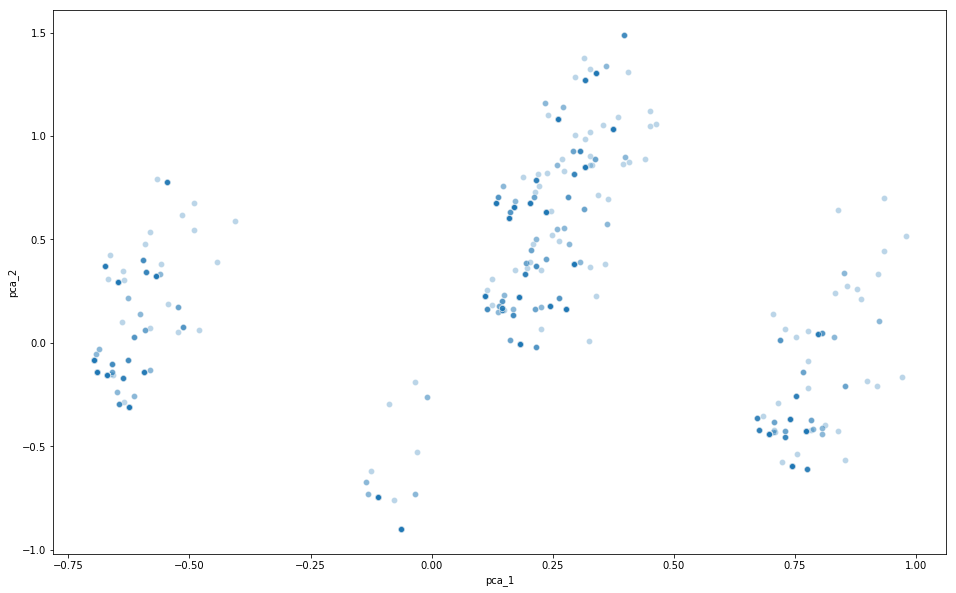

In [183]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca_1", y="pca_2",
#    hue=y,
#    palette=sns.color_palette("hls", 10),
    data=filtered_norm,
    legend="full",
    alpha=0.3
).get_figure().savefig("pca_genre.png")


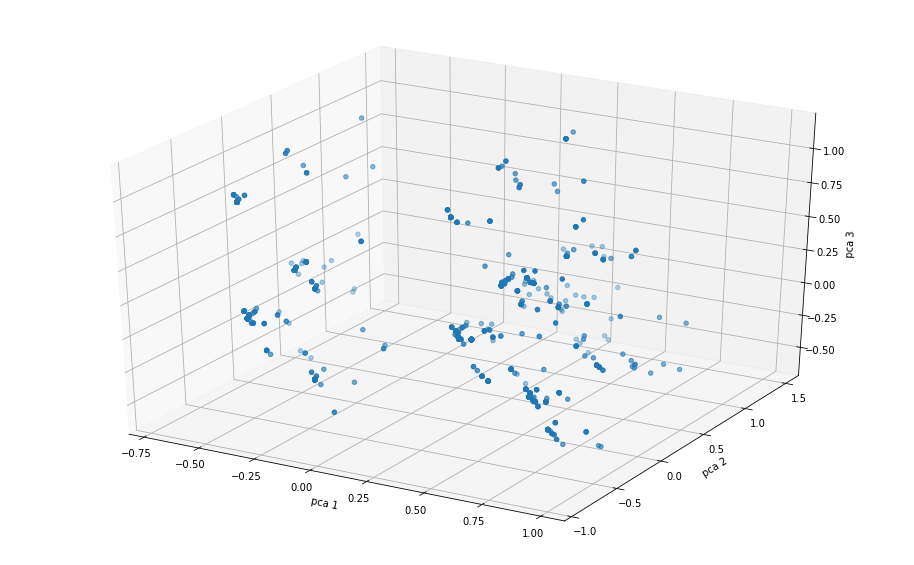

In [184]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=filtered_norm["pca_1"].astype(float), 
    ys=filtered_norm["pca_2"].astype(float), 
    zs=filtered_norm["pca_3"].astype(float), 
    #c=df.loc[rndperm,:]["y"].astype(float), 
    #cmap='tab10'
)
ax.set_xlabel('pca 1')
ax.set_ylabel('pca 2')
ax.set_zlabel('pca 3')
plt.show()

In [185]:
## Run the tSNE
filtered_norm = (filtered_values - filtered_values.min()) /  (filtered_values.max() - filtered_values.min())
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(filtered_norm)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.007s...
[t-SNE] Computed neighbors for 1682 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.626968
[t-SNE] KL divergence after 1000 iterations: 0.408604


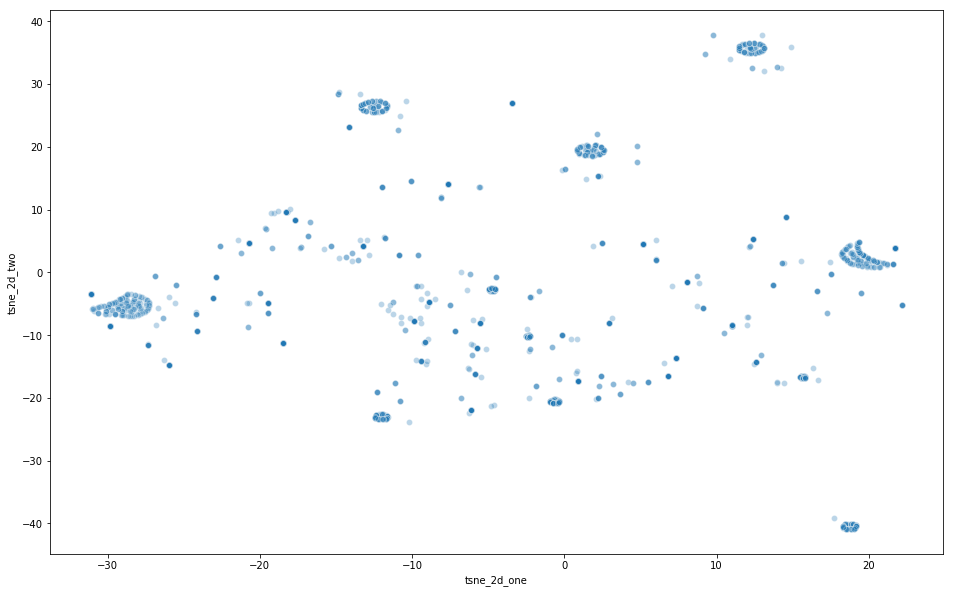

In [186]:

filtered_norm['tsne_2d_one'] = tsne_results[:,0]
filtered_norm['tsne_2d_two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns_plot = sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
#    hue=y,
    palette=sns.color_palette("hls", 20),
    data=filtered_norm,
    legend="full",
    alpha=0.3
)